# DS 5110 Final Project
## 2020 NFL Big Data Bowl
### Group 3: Anoop Nath, Lauren O'Donnell, OC Ofoma

### Introduction
Our final project is completing the [NFL Big Data Bowl](https://www.kaggle.com/competitions/nfl-big-data-bowl-2020/overview) prompt from 2020. This competition was hosted on Kaggle and asks the participants to compute the Continuous Ranked Probability Score (CRPS) for each play. The CRPS indicates the probability that a team gains that many yards on the play. The CRPS is computed by: 

$$
C = \dfrac{1}{1199} \sum^N_{m=1} \sum^{99}_{n=-99} (P(y \leq n) H(n-Y_m))^2
$$

where P is the predicted distribution, $N$ is the number of plays in the test set, $Y$ is the actual yardage and $H(x)$ is the Heaviside step function $(H(x) = 1$ for $x \geq 0$ and zero otherwise).

The submission will not score if any of the predicted values has $P(y \leq k) \ge P(y \leq k + 1)$ for any $k$ (i.e. the CDF must be non-decreasing).

Our initial goal was to compute the CRPS; however, we opted to focus on a more simple goal of predicting whether or not a play would result in a first down. As part of the DS 5110 project requirements, we generated three models utilizing techniques from this course in `pyspark`. 

### Importing Dataset
The data were provided as part of the [2020 NFL Big Data Bowl](https://www.kaggle.com/competitions/nfl-big-data-bowl-2020/) hosted on Kaggle. For this project, the data were downloaded from Kaggle locally and uploaded to a shared location. 

We utilized the resources on Rivanna to execute our project. Our data was stored and shared on Rivanna for us to use in one singular location. Code was shared on our [GitHub Repository](https://github.com/lauren-odonnell/DS5110_NFL_BigDataBowl). Please note that as the data file is rather large, it is not housed in GitHub and can be downloaded via the [2020 NFL Big Data Bowl](https://www.kaggle.com/competitions/nfl-big-data-bowl-2020/) page.

A data dictionary was provided by the 2020 NFL Big Data Bowl and used as a schema to import the data. The variables are described below.

* `GameId` - a unique game identifier
* `PlayId` - a unique play identifier
* `Team` - home or away
* `X` - player position along the long axis of the field. See figure below.
* `Y` - player position along the short axis of the field. See figure below.
* `S` - speed in yards/second
* `A` - acceleration in yards/second^2
* `Dis` - distance traveled from prior time point, in yards
* `Orientation` - orientation of player (deg)
* `Dir` - angle of player motion (deg)
* `NflId` - a unique identifier of the player
* `DisplayName` - player's name
* `JerseyNumber` - jersey number
* `Season` - year of the season
* `YardLine` - the yard line of the line of scrimmage
* `Quarter` - game quarter (1-5, 5 == overtime)
* `GameClock` - time on the game clock
* `PossessionTeam` - team with possession
* `Down` - the down (1-4)
* `Distance` - yards needed for a first down
* `FieldPosition` - which side of the field the play is happening on
* `HomeScoreBeforePlay` - home team score before play started
* `VisitorScoreBeforePlay` - visitor team score before play started
* `NflIdRusher` - the NflId of the rushing player
* `OffenseFormation` - offense formation
* `OffensePersonnel` - offensive team positional grouping
* `DefendersInTheBox` - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
* `DefensePersonnel` - defensive team positional grouping
* `PlayDirection` - direction the play is headed
* `TimeHandoff` - UTC time of the handoff
* `TimeSnap` - UTC time of the snap
* `Yards` - the yardage gained on the play
* `PlayerHeight` - player height (ft-in)
* `PlayerWeight` - player weight (lbs)
* `PlayerBirthDate` - birth date (mm/dd/yyyy)
* `PlayerCollegeName` - where the player attended college
* `Position` - the player's position (the specific role on the field that they typically play)
* `HomeTeamAbbr` - home team abbreviation
* `VisitorTeamAbbr` - visitor team abbreviation
* `Week` - week into the season
* `Stadium` - stadium where the game is being played
* `Location` - city where the game is being played
* `StadiumType` - description of the stadium environment
* `Turf` - description of the field surface
* `GameWeather` - description of the game weather
* `Temperature` - temperature (deg F)
* `Humidity` - humidity
* `WindSpeed` - wind speed in miles/hour
* `WindDirection` - wind direction* 


<img src="NFL_Data_Dictionary.png">  

In [1]:
import os
print(os.getcwd())

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("NFL_data") \
        .getOrCreate()

/sfs/qumulo/qhome/qsq6zz/ds5110/project


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/08/09 14:33:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# setting dataset schema for import

# import data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType, DateType, LongType
schema = StructType([
    StructField('GameId', IntegerType(), True),
    StructField('PlayId', LongType(), True), 
    StructField('Team', StringType(), True), 
    StructField('X', FloatType(), True), 
    StructField('Y', FloatType(), True), 
    StructField('S', FloatType(), True), 
    StructField('A', FloatType(), True), 
    StructField('Dis', FloatType(), True), 
    StructField('Orientation', FloatType(), True), 
    StructField('Dir', FloatType(), True), 
    StructField('NflId', IntegerType(), True), 
    StructField('DisplayName', StringType(), True), 
    StructField('JerseyNumber', IntegerType(), True), 
    StructField('Season', IntegerType(), True), 
    StructField('YardLine', IntegerType(), True), 
    StructField('Quarter', IntegerType(), True), 
    StructField('GameClock', TimestampType(), True), 
    StructField('PossessionTeam', StringType(), True), 
    StructField('Down', IntegerType(), True), 
    StructField('Distance', IntegerType(), True), 
    StructField('FieldPosition', StringType(), True), 
    StructField('HomeScoreBeforePlay', IntegerType(), True), 
    StructField('VisitorScoreBeforePlay', IntegerType(), True), 
    StructField('NflIdRusher', IntegerType(), True), 
    StructField('OffenseFormation', StringType(), True), 
    StructField('OffensePersonnel', StringType(), True), 
    StructField('DefendersInTheBox', IntegerType(), True), 
    StructField('DefensePersonnel', StringType(), True), 
    StructField('PlayDirection', StringType(), True), 
    StructField('TimeHandoff', TimestampType(), True), 
    StructField('TimeSnap', TimestampType(), True), 
    StructField('Yards', IntegerType(), True), 
    StructField('PlayerHeight', StringType(), True), 
    StructField('PlayerWeight', IntegerType(), True), 
    StructField('PlayerBirthDate', DateType(), True), 
    StructField('PlayerCollegeName', StringType(), True), 
    StructField('Position', StringType(), True), 
    StructField('HomeTeamAbbr', StringType(), True), 
    StructField('VisitorTeamAbbr', StringType(), True), 
    StructField('Week', IntegerType(), True), 
    StructField('Stadium', StringType(), True), 
    StructField('Location', StringType(), True), 
    StructField('StadiumType', StringType(), True), 
    StructField('Turf', StringType(), True), 
    StructField('GameWeather', StringType(), True), 
    StructField('Temperature', IntegerType(), True), 
    StructField('Humidity', IntegerType(), True), 
    StructField('WindSpeed', IntegerType(), True), 
    StructField('WindDirection', StringType(), True)])

In [3]:
path = '/sfs/qumulo/qhome/nux9aq/project/data.csv' # update as necessary; current is the shared location containing the data

df = spark.read.csv(path, header = True, schema = schema)

In [4]:
print('Number of rows: ', df.count())

Number of rows:  682154


### Data Preprocessing
The NFL data is notorious for requiring lots of wrangling, from cleaning up sensors that were worn backwards during a game to engineering variables to fit the need of the research question at hand. However, the data appeared to be fairly clean before being provided online for the Big Data Bowl competition. This saved us lots of time (thank you, NFL!!). 

In our case, we needed to generate some additional variables. We generated variables to calculate the distance to a touchdown, a variable to identify the rusher's X and Y coordinates for each play, a variable containing the Euclidean distance between the rusher and each player, a variable identifying the closest defender (which required filtering out the offensive players), and a binary variable defining whether a first down place was achieved.

In [5]:
from pyspark.sql.functions import when

# Calculate DistanceToTouchdown
df = df.withColumn('DistanceToTouchdown', 
                   when(df['PossessionTeam'] == df['FieldPosition'], 100 - df['YardLine']).otherwise(df['YardLine']))


# Identify the rusher's X and Y for each play and merge to the original DataFrame
df_rusher = df.filter(df['NflId'] == df['NflIdRusher']).select('PlayId', 'X', 'Y', 'Team')
df_rusher = df_rusher.withColumnRenamed('X', 'RusherX').withColumnRenamed('Y', 'RusherY').withColumnRenamed('Team', 'RusherTeam')
df = df.join(df_rusher, on=['PlayId'], how='inner')


# Calculate Euclidean distance between ball carrier (rusher) and each player
df = df.withColumn('PlayerDistance', ((df['X'] - df['RusherX'])**2 + (df['Y'] - df['RusherY'])**2)**0.5)


# Filter out the offensive team players
df_defenders = df.filter(df['Team'] != df['RusherTeam'])

# For each PlayId, find the minimum PlayerDistance
df_defenders = df_defenders.groupBy('PlayId').min('PlayerDistance')
df_defenders = df_defenders.withColumnRenamed('min(PlayerDistance)', 'ClosestDefenderDistance')

# Merge ClosestDefenderDistance back to the original DataFrame
df = df.join(df_defenders, on = ['PlayId'], how = 'inner')


# Define first_down_gained
df = df.withColumn('first_down_gained', when(df['Yards'] - df['Distance'] >= 0, 1).otherwise(0))

Following the generation of these additional variables, we needed to define the features and target for our models. We selected variables `DefendersInTheBox`, `Down`, `Distance`, `DistanceToTouchdown`, and `ClosestDefenderDistance` as our features and `first_down_gained` as our target variable. 

As final data preprocessing, we removed rows with null values and assembled our features into a vector column. 

In [6]:
from pyspark.ml.feature import VectorAssembler

# Define the feature columns and target variable
features = ['DefendersInTheBox', 'Down', 'Distance', 'DistanceToTouchdown', 'ClosestDefenderDistance']
target = 'first_down_gained'

# Drop rows with null values
df = df.na.drop(subset=features)

# Assemble features into a feature vector column
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
df = assembler.transform(df)

Finally, we check the schema one last time to ensure everything is set up properly for analysis. 

In [7]:
df.printSchema()

root
 |-- PlayId: long (nullable = true)
 |-- GameId: integer (nullable = true)
 |-- Team: string (nullable = true)
 |-- X: float (nullable = true)
 |-- Y: float (nullable = true)
 |-- S: float (nullable = true)
 |-- A: float (nullable = true)
 |-- Dis: float (nullable = true)
 |-- Orientation: float (nullable = true)
 |-- Dir: float (nullable = true)
 |-- NflId: integer (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- JerseyNumber: integer (nullable = true)
 |-- Season: integer (nullable = true)
 |-- YardLine: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- PossessionTeam: string (nullable = true)
 |-- Down: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- FieldPosition: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- NflIdRusher: integer (nullable = true)
 |-- OffenseFormation: string (nulla

### Data Splitting/Sampling
Before creating models, the data needed to be split. We used a 70\:20\:10 split to create a training, validation, and test set respectively. We used `seed` 420 to standardize our data splits through each run. 

In [8]:
# Split the data into train, validate and test datasets
seed = 420
train, val, test = df.randomSplit([0.7, 0.2, 0.1], seed = seed)

### Exploratory Data Analysis (EDA)

Beginning EDA, we first needed to group the data by each play as each player's data was listed for each play. To confirm the standardization of the data, we executed a count of each `PlayId` to confirm there was data for 22 players on each `PlayId`. 

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, col
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [10]:
plays= df.groupBy('PlayId').count()
plays.show()

+--------------+-----+
|        PlayId|count|
+--------------+-----+
|20170907000118|   22|
|20170907000139|   22|
|20170907000189|   22|
|20170907000345|   22|
|20170907000395|   22|
|20170907000473|   22|
|20170907000516|   22|
|20170907000653|   22|
|20170907000680|   22|
|20170907000801|   22|
|20170907000917|   22|
|20170907001004|   22|
|20170907001077|   22|
|20170907001156|   22|
|20170907001177|   22|
|20170907001296|   22|
|20170907001355|   22|
|20170907001376|   22|
|20170907001443|   22|
|20170907001488|   22|
+--------------+-----+
only showing top 20 rows



We then computed the total number of plays in the dataset, returnining a value of 31,006 total plays. 

In [11]:
#how many plays are in the dataset?
print('Number of plays: ', df.select('PlayId').distinct().count())

Number of plays:  31006


Based on subject knowledge around American football, one of the more important predictors will be how far away the offensive team is to the endzone. This was not explicitly listed in the data and can be derived using the constructed `DistanceToTouchdown` variable. 

Our target variable we will be trying to predict is `first_down_gained`. Below is a statistical summary of `first_down_gained`.

In [12]:
train.select('first_down_gained').summary().show()

+-------+------------------+
|summary| first_down_gained|
+-------+------------------+
|  count|            476831|
|   mean|0.2128049560536123|
| stddev|0.4092912875333734|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 0|
|    max|                 1|
+-------+------------------+



Next, we looked at the statistical summary for potential predictor variables 

In [13]:
train.select('DefendersInTheBox', 'Down','Distance', 'DistanceToTouchdown', 'ClosestDefenderDistance').summary().show()

+-------+------------------+------------------+-----------------+-------------------+-----------------------+
|summary| DefendersInTheBox|              Down|         Distance|DistanceToTouchdown|ClosestDefenderDistance|
+-------+------------------+------------------+-----------------+-------------------+-----------------------+
|  count|            476831|            476831|           476831|             476831|                 476831|
|   mean|  6.91068743433208|1.5159291237356631|8.319685590911664|  51.64061900337855|      4.582833709014569|
| stddev|0.9856141225837932|0.6756290042566845|3.813255695732436| 25.252908902506366|     0.9724321472815692|
|    min|                 2|                 1|                1|                  1|     0.2308711463553317|
|    25%|                 6|                 1|                6|                 32|      3.967277342925264|
|    50%|                 7|                 1|               10|                 56|      4.591664698790464|
|    75%| 

We then explored the correlations between the variables, specifically focusing in on the relationships with `first_down_gained`. The strongest correlation with `first_down_gained` appeared to be with `Distance`. The correlation matrix revealed a strong negative correlation. 

In [15]:
from pyspark.ml.stat import Correlation

non_string_vars = [ 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'YardLine', 'Quarter', 'Down', 
                   'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 
                   'DefendersInTheBox', 'Yards', 'PlayerWeight', 'Temperature', 'Humidity', 'WindSpeed',
                   'DistanceToTouchdown', 'ClosestDefenderDistance', 'first_down_gained'
                  ]

# convert to vector column first
assembler = VectorAssembler(inputCols=non_string_vars, outputCol="corr_features", handleInvalid="skip")
df_vector = assembler.transform(df).select("corr_features")

# get correlation matrix
matrix = Correlation.corr(df_vector, "corr_features")

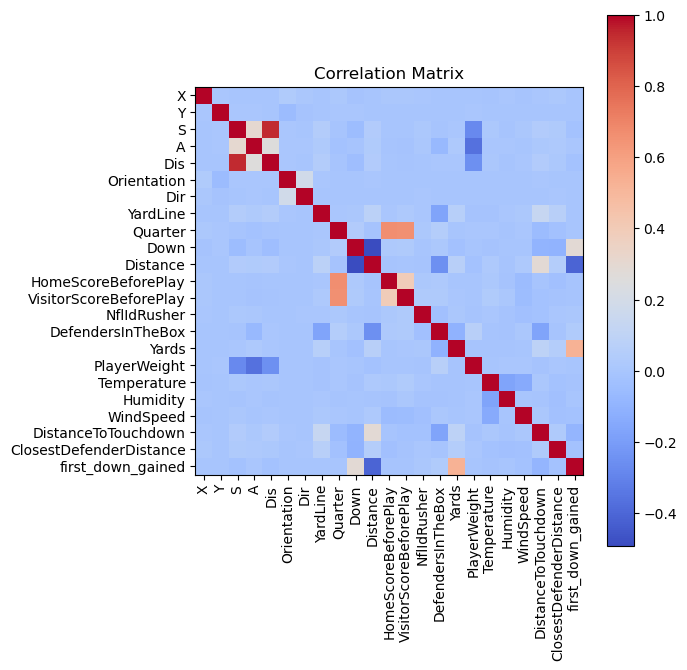

In [16]:
correlation_array = matrix.select("pearson(corr_features)").collect()[0]["pearson(corr_features)"].toArray()
correlation_df = pd.DataFrame(correlation_array, columns=non_string_vars, index=non_string_vars)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(7, 7))
plt.imshow(correlation_df, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.title("Correlation Matrix")
plt.xticks(range(len(non_string_vars)), non_string_vars, rotation=90)
plt.yticks(range(len(non_string_vars)), non_string_vars)
plt.tight_layout()
plt.show()

Finally, we explored the distributions of first downs achieved in the dataset using a violin plot and calculated the total numbe of first downs achieved during plays, which resulted in 21.26%. 

In [14]:
# converting training data to a pandas dataframe for visualization
pandas_df = train.toPandas()

23/08/09 14:35:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Text(0, 0, 'No First Down'), Text(1, 0, 'First Down')]

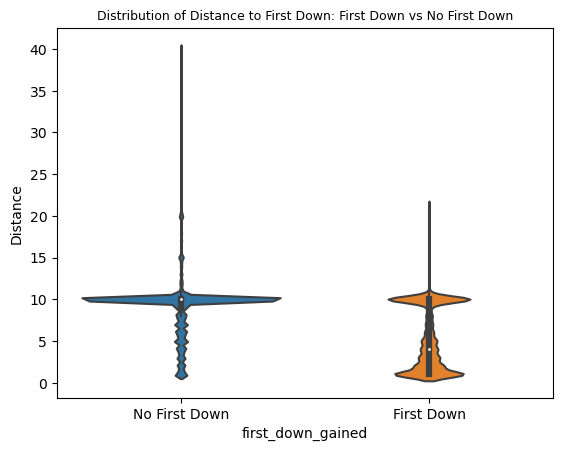

In [46]:
violin = sns.violinplot(data=pandas_df, x="first_down_gained", y="Distance")
violin.set_title('Distribution of Distance to First Down: First Down vs No First Down', fontsize=9);
violin.set_xticklabels(['No First Down','First Down'])

In [51]:
percent_first_downs_gained = df.filter(df['first_down_gained'] == 1).count() / df.count()
print('Percentage of Plays Resulting in a First Down: {:.2f}%'.format(percent_first_downs_gained * 100))

Percentage of Plays Resulting in a First Down: 21.26%


### Model Construction
Each of our models were fit using the training set and validated using cross validation with 5 folds with the validation set. To prepare to evaluate the models, evaluators were created and a function for cross validation was prepared.  

In [17]:
# Generating Evaluators

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol='prediction')
evaluator_b = BinaryClassificationEvaluator(labelCol=target, rawPredictionCol='rawPrediction')

In [18]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


def crossvalidation(estimator):
    if isinstance(estimator, (LogisticRegression, GBTClassifier)):
        paramGrid = ParamGridBuilder().addGrid(estimator.maxIter, [10]).build()
    else:
        paramGrid = ParamGridBuilder() \
            .addGrid(estimator.numTrees, [10]) \
            .addGrid(estimator.maxDepth, [5]) \
            .build()

    crossval = CrossValidator(
        estimator=estimator,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=5,
        parallelism=2,
        seed=seed
    )
    
    model = crossval.fit(df)
    
    return model

#### Model 1: Logistic Regression
We opted for our benchmark model to be a logistic regression model. Our feature variables were `DefendersInTheBox`, `Down`, `Distance`, `DistanceToTouchdown`, and `ClosestDefenderDistance`, which were assembled into a vector column during preprocessing. Our target variable was `first_down_gained`. The goal is to classify whether or not the play would result in a first down. 

In [19]:
# Create a logistic regression model
lr = LogisticRegression(labelCol=target, featuresCol='features')

In [20]:
# data splitting model

# Fit the model with the training data (data splitting)
lr_model = lr.fit(train)

# Predict the target variable on the validation data
lr_predictions = lr_model.transform(val)

In [21]:
#cross validation model

# model with cross validation
lr_model_cv = crossvalidation(lr)

# predict the target variable on the cross validation model
lr_predictions_cv = lr_model_cv.transform(df)

After training the model, it was evaluated and accuracy, precision, recall, F1 scores, and AUC were calculated. These scores were followed by the generation of a confusion matrix.

In [22]:
# evaluation metrics of data splitting model
print('Logistic Regression: Data Splitting Results')

# Accuracy
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: 'accuracy'})
print('Accuracy: {:.2f}%'.format(lr_accuracy * 100))

# Precision
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: 'weightedPrecision'})
print('Precision: {:.2f}%'.format(lr_precision * 100))

# Recall
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: 'weightedRecall'})
print('Recall: {:.2f}%'.format(lr_recall * 100))

# F1 Score
lr_f1Score = evaluator.evaluate(lr_predictions, {evaluator.metricName: 'f1'})
print('F1 Score: {:.4f}'.format(lr_f1Score))

# AUC
lr_auc = evaluator_b.evaluate(lr_predictions, {evaluator_b.metricName: 'areaUnderROC'})
print('AUC: {:.4f}'.format(lr_auc))

Logistic Regression: Data Splitting Results


Accuracy: 82.56%


Precision: 80.87%


Recall: 82.56%


F1 Score: 0.8087


AUC: 0.7628


In [23]:
# evaluation metrics of cross validation model
print('Logistic Regression: Cross-Validation Results')

# Accuracy
lr_accuracy_cv = evaluator.evaluate(lr_predictions_cv, {evaluator.metricName: 'accuracy'})
print('Accuracy: {:.2f}%'.format(lr_accuracy_cv * 100))

# Precision
lr_precision_cv = evaluator.evaluate(lr_predictions_cv, {evaluator.metricName: 'weightedPrecision'})
print('Precision: {:.2f}%'.format(lr_precision_cv * 100))

# Recall
lr_recall_cv = evaluator.evaluate(lr_predictions_cv, {evaluator.metricName: 'weightedRecall'})
print('Recall: {:.2f}%'.format(lr_recall_cv * 100))

# F1 Score
lr_f1Score_cv = evaluator.evaluate(lr_predictions_cv, {evaluator.metricName: 'f1'})
print('F1 Score: {:.4f}'.format(lr_f1Score_cv))

# AUC
lr_auc_cv = evaluator_b.evaluate(lr_predictions_cv, {evaluator_b.metricName: 'areaUnderROC'})
print('AUC: {:.4f}'.format(lr_auc_cv))

Logistic Regression: Cross-Validation Results


Accuracy: 82.63%


Precision: 80.95%


Recall: 82.63%


F1 Score: 0.8096


AUC: 0.7625


23/08/09 14:59:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


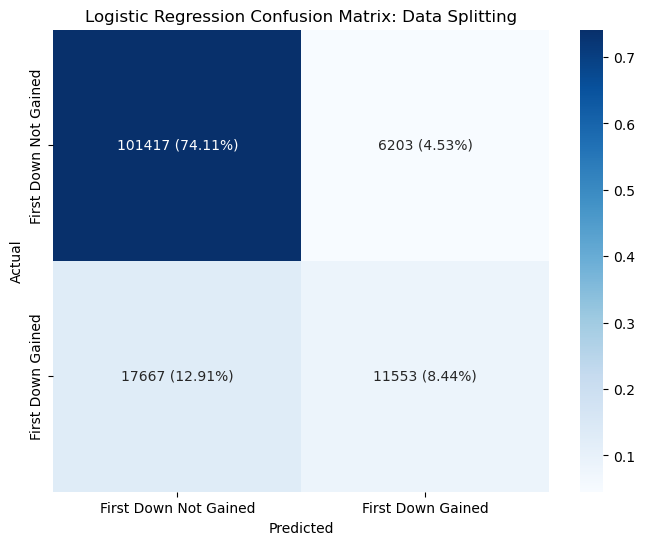

In [24]:
from sklearn.metrics import confusion_matrix

# Data Splitting Confusion Matrix

# Convert PySpark DataFrame columns to lists
y_true = [row[0] for row in lr_predictions.select(target).collect()]
y_pred = [row[0] for row in lr_predictions.select('prediction').collect()]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='all')

# Combine the raw counts with the normalized percentages
combined_cm = np.array([[f'{c} ({p * 100:.2f}%)' for c, p in zip(row_c, row_p)] for row_c, row_p in zip(cm, cm_normalized)])

# Visualize the combined confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=combined_cm, fmt='', cmap='Blues', 
            xticklabels=['First Down Not Gained', 'First Down Gained'], 
            yticklabels=['First Down Not Gained', 'First Down Gained'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix: Data Splitting')
plt.show()

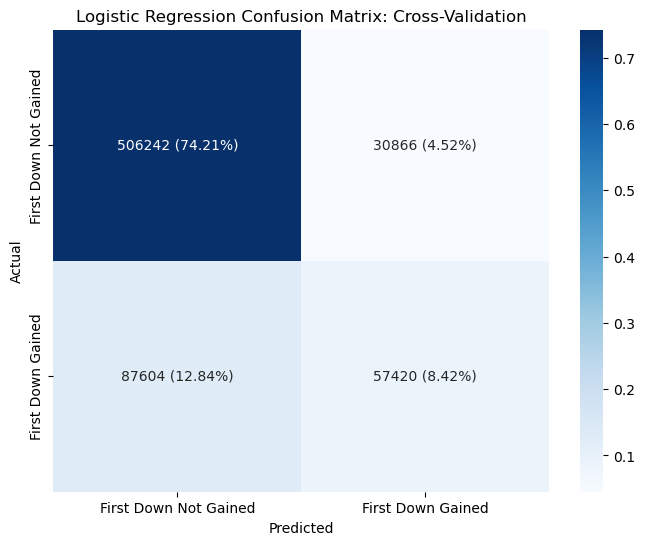

In [25]:
# Cross-Validation Confusion Matrix

# Convert PySpark DataFrame columns to lists
y_true = [row[0] for row in lr_predictions_cv.select(target).collect()]
y_pred = [row[0] for row in lr_predictions_cv.select('prediction').collect()]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='all')

# Combine the raw counts with the normalized percentages
combined_cm = np.array([[f'{c} ({p * 100:.2f}%)' for c, p in zip(row_c, row_p)] for row_c, row_p in zip(cm, cm_normalized)])

# Visualize the combined confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=combined_cm, fmt='', cmap='Blues', 
            xticklabels=['First Down Not Gained', 'First Down Gained'], 
            yticklabels=['First Down Not Gained', 'First Down Gained'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix: Cross-Validation')
plt.show()

Overall, this model performed decently. As a simple benchmark model, we resulted in an accuracy of 82.56%. The precision and recall rates were also decent, returning 80.87% an 82.56% respectively. The F1 Score was 0.8087 and the AUC was 0.7628. 

When running the model a second time with k-fold cross-validation, the metrics improved slightly to an accuracy of 82.63%, precision of 80.95%, recall of 82.63%, F1 score of 0.8096, and AUC of 0.7625. 

Based on these benchmark models, we are hoping we can at least achieve an AUC of 0.8 with our following models. 

#### Model 2: Gradient Boosted Tree
Our second model was a gradient boosted tree. We selected a gradient boosted tree as this ensemble model performs classification or regression by combining outputs from individual trees. Gradient boosted trees utilize boosting, which utilizes weak learners sequentially to correct errors from previous trees. 

In [26]:
# Create the DBT Model
gbt = GBTClassifier(labelCol=target, featuresCol='features', seed=seed)

In [27]:
# data splitting model

# Fit the model with the training data (data splitting)
gbt_model = gbt.fit(train)

# Predict the target variable on the validation data
gbt_predictions = gbt_model.transform(val)

In [28]:
# cross validation model

# model with cross validation
gbt_model_cv = crossvalidation(gbt)

# predict the target variable on the cross validation model
gbt_predictions_cv = gbt_model_cv.transform(df)

In [29]:
# evaluation metrics of data splitting model
print('Gradient Boosted Tree: Data Splitting Results')

# Accuracy
gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'accuracy'})
print('Accuracy: {:.2f}%'.format(gbt_accuracy * 100))

# Precision
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'weightedPrecision'})
print('Precision: {:.2f}%'.format(gbt_precision * 100))

# Recall
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'weightedRecall'})
print('Recall: {:.2f}%'.format(gbt_recall * 100))

# F1 Score
gbt_f1Score = evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'f1'})
print('F1 Score: {:.4f}'.format(gbt_f1Score))

# AUC
gbt_auc = evaluator_b.evaluate(gbt_predictions, {evaluator_b.metricName: 'areaUnderROC'})
print('AUC: {:.4f}'.format(gbt_auc))

Gradient Boosted Tree: Data Splitting Results


Accuracy: 83.14%


Precision: 81.61%


Recall: 83.14%


F1 Score: 0.8150


AUC: 0.7788


In [30]:
# evaluation metrics of cross-validation model
print('Gradient Boosted Tree: Cross-Validation Results')

# Accuracy
gbt_accuracy_cv = evaluator.evaluate(gbt_predictions_cv, {evaluator.metricName: 'accuracy'})
print('Accuracy: {:.2f}%'.format(gbt_accuracy_cv * 100))

# Precision
gbt_precision_cv = evaluator.evaluate(gbt_predictions_cv, {evaluator.metricName: 'weightedPrecision'})
print('Precision: {:.2f}%'.format(gbt_precision_cv * 100))

# Recall
gbt_recall_cv = evaluator.evaluate(gbt_predictions_cv, {evaluator.metricName: 'weightedRecall'})
print('Recall: {:.2f}%'.format(gbt_recall_cv * 100))

# F1 Score
gbt_f1Score_cv = evaluator.evaluate(gbt_predictions_cv, {evaluator.metricName: 'f1'})
print('F1 Score: {:.4f}'.format(gbt_f1Score_cv))

# AUC
gbt_auc_cv = evaluator_b.evaluate(gbt_predictions_cv, {evaluator_b.metricName: 'areaUnderROC'})
print('AUC: {:.4f}'.format(gbt_auc_cv))

Gradient Boosted Tree: Cross-Validation Results


Accuracy: 83.01%


Precision: 81.45%


Recall: 83.01%


F1 Score: 0.8145


AUC: 0.7750


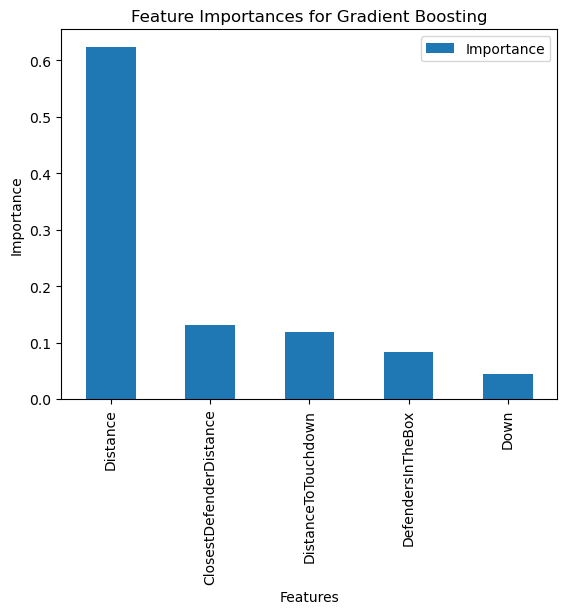

In [40]:
# importance of variables for data splitting model

# Assuming 'model' is the trained RandomForestClassifier or RandomForestRegressor
gbt_importances = gbt_model.featureImportances

# Convert feature importances to a Pandas DataFrame for easier visualization
gbt_importances_df = pd.DataFrame(gbt_importances.toArray(), columns=['Importance'], index=features)

# Sort the features by importance and plot a bar chart
gbt_importances_df.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances for Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

The data splitting gradient boosting model returned higher metrics than our benchmark logistic regression model, improving on every metric in both the data splitting cross-validation model and the k-folds cross-validation model. For the data splitting model, our metrics resulted in an accuracy of 83.14%, precision of 81.61%, recall of 83.14%, F1 score of 0.8150, and AUC of 0.7788. The k-fold cross-validated model performed only slightly worse than with data splitting returning an accuracy of 83.01%, precision of 81.45%, recall of 83.01%, F1 score of 0.8145, and AUC of 0.7750. 

The gradient boosting models returned the most important variable as Distance. This was not a surprising result given the suggestions from EDA prior to model construction. 

#### Model 3: Random Forest
The final model generated was a random forest model. Random forests, like gradient boosted trees, is an ensemble model that can perform classification or regression by combining outputs from individual trees. The primary difference between gradient boosted trees and random forests is random forests utilize the bagging method to construct individual decision trees. 

In [31]:
# Create the RandomForestClassifier
rf = RandomForestClassifier(numTrees=10, maxDepth=5, labelCol=target, featuresCol='features', seed=seed)

In [32]:
# data splitting model

# Train the model
rf_model = rf.fit(train)

# Make predictions on the test set
rf_predictions = rf_model.transform(test)

In [33]:
# cross-validation model

# model with cross validation
rf_model_cv = crossvalidation(rf)

# predict the target variable on the cross validation model
rf_predictions_cv = rf_model_cv.transform(df)

In [34]:
# evaluation metrics of data splitting model
print('Random Forest: Data Splitting Results')

rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: 'accuracy'})
print('Accuracy: {:.2f}%'.format(rf_accuracy * 100))

rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: 'weightedPrecision'})
print('Precision: {:.2f}%'.format(rf_precision * 100))

rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: 'weightedRecall'})
print('Recall: {:.2f}%'.format(rf_recall * 100))

rf_f1Score = evaluator.evaluate(rf_predictions, {evaluator.metricName: 'f1'})
print('F1 Score: {:.4f}'.format(rf_f1Score))

rf_auc = evaluator_b.evaluate(rf_predictions, {evaluator_b.metricName: 'areaUnderROC'})
print('AUC: {:.4f}'.format(rf_auc))

Random Forest: Data Splitting Results


Accuracy: 83.01%


Precision: 81.45%


Recall: 83.01%


F1 Score: 0.8160


AUC: 0.7655


In [35]:
# evaluation metrics of cross-validation model
print('Random Forest: Cross-Validation Results')

rf_accuracy_cv = evaluator.evaluate(rf_predictions_cv, {evaluator.metricName: 'accuracy'})
print('Accuracy: {:.2f}%'.format(rf_accuracy_cv * 100))

rf_precision_cv = evaluator.evaluate(rf_predictions_cv, {evaluator.metricName: 'weightedPrecision'})
print('Precision: {:.2f}%'.format(rf_precision_cv * 100))

rf_recall_cv = evaluator.evaluate(rf_predictions_cv, {evaluator.metricName: 'weightedRecall'})
print('Recall: {:.2f}%'.format(rf_recall_cv * 100))

rf_f1Score_cv = evaluator.evaluate(rf_predictions_cv, {evaluator.metricName: 'f1'})
print('F1 Score: {:.4f}'.format(rf_f1Score_cv))

rf_auc_cv = evaluator_b.evaluate(rf_predictions_cv, {evaluator_b.metricName: 'areaUnderROC'})
print('AUC: {:.4f}'.format(rf_auc_cv))

Random Forest: Cross-Validation Results


Accuracy: 82.85%


Precision: 81.26%


Recall: 82.85%


F1 Score: 0.8131


AUC: 0.7616


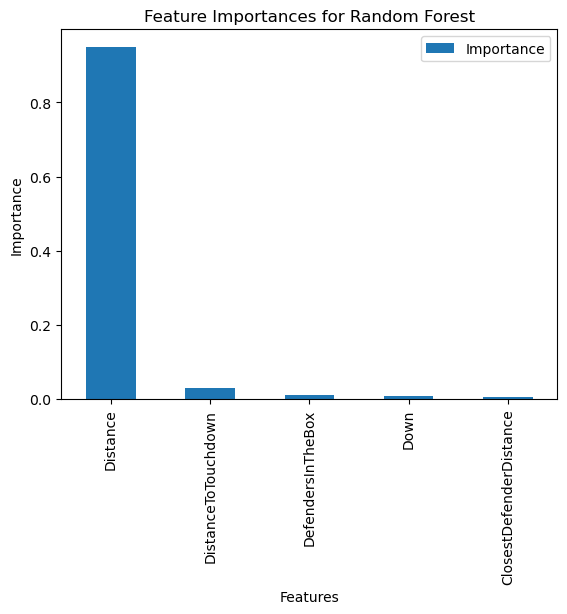

In [39]:
# importance of variables

# Assuming 'model' is the trained RandomForestClassifier or RandomForestRegressor
rf_importances = rf_model.featureImportances

# Convert feature importances to a Pandas DataFrame for easier visualization
rf_importances_df = pd.DataFrame(rf_importances.toArray(), columns=['Importance'], index=features)

# Sort the features by importance and plot a bar chart
rf_importances_df.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances for Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In the random forest model the variable Distance was the resounding most important variable in the model, agreeing with the gradient boosting model’s most important variable and analysis from EDA. The second most important variables, though appearing to be significantly less important than Distance, were different between the random forest model and the gradient boosting model. 

### Model Evaluation
All of the models generated performed fairly similarly. Overall, the best performance was the gradient boosted tree. Our champion gradient boosted models performed slightly better than the other models with all metrics, both with data splitting and k-fold cross-validation. 


| Model                                | Accuracy | Precision | Recall | F1 Score | AUC    |
|--------------------------------------|----------|-----------|--------|----------|--------|
| Logistic Regression (Data Splitting) | 82.56%   | 80.87%    | 82.56% | 0.8087   | 0.7628 |
| Logistic Regression (k-Fold CV)      | 82.63%   | 80.95%    | 82.63% | 0.8096   | 0.7625 |
| Gradient Boosting (Data Splitting)   | 83.14%   | 81.61%    | 83.14% | 0.8150   | 0.7789 |
| Gradient Boosting (k-Fold CV)        | 83.01%   | 81.45%    | 83.01% | 0.8145   | 0.7750 |
| Random Forest (Data Splitting)       | 83.01%   | 81.45%    | 83.01% | 0.8160   | 0.7655 |
| Random Forest (k-Fold CV)            | 82.85%   | 81.26%    | 82.85% | 0.8131   | 0.7616 |